In [164]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import demoji
import emoji
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import gensim
import keras
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.layers import Input, Reshape, Conv2D, MaxPool2D, Concatenate, Flatten, Embedding, Dropout, Dense, Bidirectional, LSTM, GRU
from keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import tensorflow_hub as hub
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, precision_score, accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
import tensorflow_text as text
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

### 1. Loading the dataset

In [147]:
train  = pd.read_csv('SemEval2018-T3-train-taskA_emoji.txt', sep="\t", encoding="utf-8")
test = pd.read_csv('SemEval2018-T3_gold_test_taskA_emoji.txt', sep="\t", encoding="utf-8")
train.head()

,Tweet index,Label,Tweet text
0,1,1,Sweet United Nations video. Just in time for Christmas. #imagine #NoReligion http://t.co/fej2v3...
1,2,1,@mrdahl87 We are rumored to have talked to Erv's agent... and the Angels asked about Ed Escobar....
2,3,1,Hey there! Nice to see you Minnesota/ND Winter Weather
3,4,0,3 episodes left I'm dying over here
4,5,1,I can't breathe! was chosen as the most notable quote of the year in an annual list released by ...


### 2. Analysing the Data

In [148]:
print("Number of train tweets:" , train['Label'].count())
print("Number of test tweets:" , test['Label'].count())

Number of train tweets: 3817
Number of test tweets: 784


In [149]:
print("Number of non-sarcastic tweets (train_dataset):", train['Label'][train['Label'] == 0].count())
print("Number of sarcastic tweets (train_dataset):", train['Label'][train['Label'] == 1].count())

Number of non-sarcastic tweets (train_dataset): 1916
Number of sarcastic tweets (train_dataset): 1901


In [150]:
print("Number of non-sarcastic tweets (test_dataset):", test['Label'][test['Label'] == 0].count())
print("Number of sarcastic tweets (test_dataset):", test['Label'][test['Label'] == 1].count())

Number of non-sarcastic tweets (test_dataset): 473
Number of sarcastic tweets (test_dataset): 311


### 3. Data Preprocessing

1. Converting to lowercase
2. Removing user handles
3. Removing URLs
4. Converting contractions to long format
5. Removing hashtags
6. Removing punctuations and special characters
7. Removing stopwords
8. Lemmatizing
9. Stemming

In [151]:
train['Clean_Tweet'] = train['Tweet text'].str.lower()

train['Clean_Tweet'] = train['Clean_Tweet'].str.replace("@[\w]*", "", regex=True)
train['Clean_Tweet'] = train['Clean_Tweet'].str.replace("\/?https?:\/?\/?[^\s]*", " ", regex=True)

''''
for i in range(len(train)):
    #train['emoji'] = 
    print(demoji.findall(str(train['Clean_Tweet'][i])).values())
'''
for i in range(len(train)):
    train['Clean_Tweet'][i] = contractions.fix(train['Clean_Tweet'][i])

bert_train = train['Clean_Tweet'].copy()
train['Clean_Tweet'] = train['Clean_Tweet'].str.replace("[^a-zA-Z#]", " ", regex=True)
train['Clean_Tweet'] = train['Clean_Tweet'].str.replace('#', '', case=False)
#train['Clean_Tweet'] = train['Clean_Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

stop = stopwords.words('english')
train['Clean_Tweet_2'] = train['Clean_Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

lemmatizer = nltk.stem.WordNetLemmatizer()
train['Clean_Tweet_2'] = train['Clean_Tweet_2'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

ps = PorterStemmer()
train['Clean_Tweet_2'] = train['Clean_Tweet_2'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

pd.options.display.max_colwidth = 100
train.head(10)

/tmp/ipykernel_42575/3089476424.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Clean_Tweet'][i] = contractions.fix(train['Clean_Tweet'][i])


,Tweet index,Label,Tweet text,Clean_Tweet,Clean_Tweet_2
0,1,1,Sweet United Nations video. Just in time for Christmas. #imagine #NoReligion http://t.co/fej2v3...,sweet united nations video just in time for christmas imagine noreligion,sweet unit nation video time christma imagin noreligion
1,2,1,@mrdahl87 We are rumored to have talked to Erv's agent... and the Angels asked about Ed Escobar....,we are rumored to have talked to erv s agent and the angels asked about ed escobar that i...,rumor talk erv agent angel ask ed escobar hardli noth
2,3,1,Hey there! Nice to see you Minnesota/ND Winter Weather,hey there nice to see you minnesota nd winter weather,hey nice see minnesota nd winter weather
3,4,0,3 episodes left I'm dying over here,episodes left i am dying over here,episod left die
4,5,1,I can't breathe! was chosen as the most notable quote of the year in an annual list released by ...,i cannot breathe was chosen as the most notable quote of the year in an annual list released by...,cannot breath chosen notabl quot year annual list releas yale univers librarian
5,6,0,You're never too old for Footie Pajamas. http://t.co/ElzGqsX2yQ,you are never too old for footie pajamas,never old footi pajama
6,7,1,Nothing makes me happier then getting on the highway and seeing break lights light up like a Chr...,nothing makes me happier then getting on the highway and seeing break lights light up like a chr...,noth make happier get highway see break light light like christma tree
7,8,0,4:30 an opening my first beer now gonna be a long night/day,an opening my first beer now going to be a long night day,open first beer go long night day
8,9,0,@Adam_Klug do you think you would support a guy who knocked out your daughter? Rice doesn't dese...,do you think you would support a guy who knocked out your daughter rice does not deserve support,think would support guy knock daughter rice deserv support
9,10,0,@samcguigan544 You are not allowed to open that until Christmas day!,you are not allowed to open that until christmas day,allow open christma day


In [152]:
test['Clean_Tweet'] = test['Tweet text'].str.lower()

test['Clean_Tweet'] = test['Clean_Tweet'].str.replace("@[\w]*", "", regex=True)
test['Clean_Tweet'] = test['Clean_Tweet'].str.replace("\/?https?:\/?\/?[^\s]*", " ", regex=True)

'''
for i in range(len(test)):
    #test['emoji'] = 
    print(demoji.findall(str(test['Clean_Tweet'][i])).values())
'''
for i in range(len(test)):
    test['Clean_Tweet'][i] = contractions.fix(test['Clean_Tweet'][i])

bert_test = test['Clean_Tweet'].copy()
test['Clean_Tweet'] = test['Clean_Tweet'].str.replace("[^a-zA-Z#]", " ", regex=True)
test['Clean_Tweet'] = test['Clean_Tweet'].str.replace('#', '', case=False)
#train['Clean_Tweet'] = train['Clean_Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

stop = stopwords.words('english')
test['Clean_Tweet_2'] = test['Clean_Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

lemmatizer = nltk.stem.WordNetLemmatizer()
test['Clean_Tweet_2'] = test['Clean_Tweet_2'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

ps = PorterStemmer()
test['Clean_Tweet_2'] = test['Clean_Tweet_2'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

pd.options.display.max_colwidth = 100
test.head()

/tmp/ipykernel_42575/1459711782.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Clean_Tweet'][i] = contractions.fix(test['Clean_Tweet'][i])


,Tweet index,Label,Tweet text,Clean_Tweet,Clean_Tweet_2
0,1,0,@Callisto1947 Can U Help?||More conservatives needed on #TSU + get paid 4 posting stuff like thi...,can you help more conservatives needed on tsu get paid posting stuff like this you ca...,help conserv need tsu get paid post stuff like go
1,2,1,"Just walked in to #Starbucks and asked for a ""tall blonde"" Hahahaha #irony",just walked in to starbucks and asked for a tall blonde hahahaha irony,walk starbuck ask tall blond hahahaha ironi
2,3,0,#NOT GONNA WIN http://t.co/Mc9ebqjAqj,not going to win,go win
3,4,0,@mickymantell He is exactly that sort of person. Weirdo!,he is exactly that sort of person weirdo,exactli sort person weirdo
4,5,1,So much #sarcasm at work mate 10/10 #boring 100% #dead mate full on #shit absolutely #sleeping m...,so much sarcasm at work mate boring dead mate full on shit absolutely sleeping mate c...,much sarcasm work mate bore dead mate full shit absolut sleep mate cannot handl sarcasm


#### Word cloud for sarcastic tweets (training dataset)

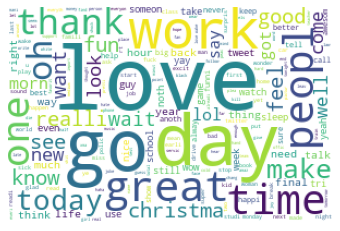

In [153]:
words = ' '.join([text for text in train['Clean_Tweet_2'][train['Label'] == 1]])
word_cloud = WordCloud(width=300, height=200, background_color ='white', random_state=53, 
                       max_font_size=80).generate(words)
#plt.figure(figsize=(8, 12))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

#### Word cloud for sarcastic tweets (test dataset)

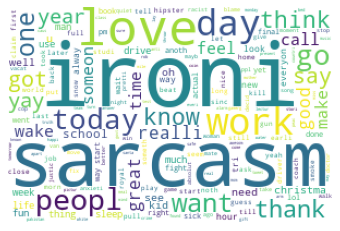

In [154]:
words = ' '.join([text for text in test['Clean_Tweet_2'][test['Label'] == 1]])
word_cloud = WordCloud(width=300, height=200, background_color ='white', random_state=53, 
                       max_font_size=80).generate(words)
#plt.figure(figsize=(8, 12))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### 4. Classification

#### 4.1. Support Vector Machine (TF-IDF)

In [474]:
def refresh_data():
    vectorizer = TfidfVectorizer(max_features = 800)

    X_train=vectorizer.fit_transform(train['Clean_Tweet_2']).toarray()
    y_train=train['Label'].copy()
    
    X_test=vectorizer.transform(test['Clean_Tweet_2']).toarray()
    y_test=test['Label'].copy()
    
    return (X_train,y_train,X_test,y_test)

In [172]:
vectorizer = TfidfVectorizer(max_features = 800)

X_train=vectorizer.fit_transform(train['Clean_Tweet_2']).toarray()
y_train=train['Label']
    
X_test=vectorizer.transform(test['Clean_Tweet_2']).toarray()
y_test=test['Label']

In [159]:
def stats():
    print(classification_report(y_test,y_predicted))
    accuracy_value = accuracy_score(y_test,y_predicted)
    precision_value = precision_score(y_test,y_predicted,average='weighted')
    f1_value = f1_score(y_test,y_predicted,average='weighted')
    
    # Confusion Matrix Plot
    cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_predicted), display_labels=['ironic', 'non_ironic'])
    cm.plot(cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True Label')
    plt.show()

              precision    recall  f1-score   support

           0       0.75      0.67      0.70       473
           1       0.56      0.65      0.61       311

    accuracy                           0.66       784
   macro avg       0.65      0.66      0.65       784
weighted avg       0.67      0.66      0.67       784



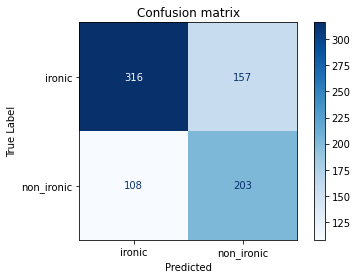

In [162]:
classifier = SVC(probability=True)
classifier.fit(X_train, y_train)
y_predicted = classifier.predict(X_test)

stats()

#### 4.2. Random Forest (TF-IDF)

              precision    recall  f1-score   support

           0       0.73      0.66      0.69       473
           1       0.55      0.63      0.59       311

    accuracy                           0.65       784
   macro avg       0.64      0.64      0.64       784
weighted avg       0.66      0.65      0.65       784



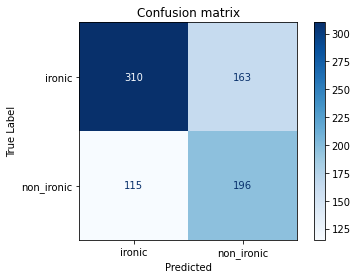

In [163]:
classificator = RandomForestClassifier()
classificator.fit(X_train, y_train)
y_predicted = classificator.predict(X_test)

stats()

#### 4.3. Multi Layer Perceptron (TF-IDF)

              precision    recall  f1-score   support

           0       0.76      0.60      0.67       473
           1       0.54      0.71      0.61       311

    accuracy                           0.64       784
   macro avg       0.65      0.65      0.64       784
weighted avg       0.67      0.64      0.65       784



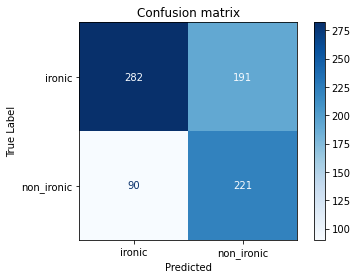

In [173]:
scaler = StandardScaler()
classificator = MLPClassifier(max_iter = 1000,activation = 'relu', solver = 'adam', random_state = 323)

classificator.fit(X_train, y_train)
y_predicted = classificator.predict(X_test)

stats()

#### 4.4. Support Vector Machine (word2vec)

In [166]:
embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")

In [167]:
embed_train = embed(train['Clean_Tweet_2'])
embed_test = embed(test['Clean_Tweet_2'])

              precision    recall  f1-score   support

           0       0.71      0.62      0.66       473
           1       0.52      0.62      0.56       311

    accuracy                           0.62       784
   macro avg       0.61      0.62      0.61       784
weighted avg       0.63      0.62      0.62       784



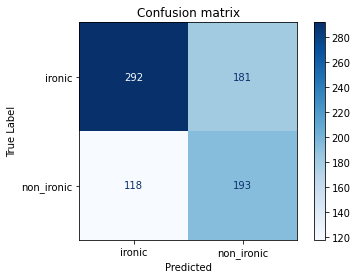

In [169]:
classificator = SVC(probability=True)
classificator.fit(embed_train, train['Label'])
y_predicted=classificator.predict(embed_test)

stats()

#### 4.5. Pre-trained BERT model

In [234]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [235]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [236]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [237]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_12 (KerasLayer)    {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                   

In [238]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=Metrics)

In [244]:
model.fit(bert_train, train['Label'], epochs=200)

Epoch 1/200
120/120 [==============================] - 17s 143ms/step - loss: 0.6647 - accuracy: 0.6020 - precision: 0.6029 - recall: 0.5886
Epoch 2/200
120/120 [==============================] - 17s 142ms/step - loss: 0.6647 - accuracy: 0.6020 - precision: 0.6019 - recall: 0.5934
Epoch 3/200
120/120 [==============================] - 17s 142ms/step - loss: 0.6595 - accuracy: 0.6089 - precision: 0.6098 - recall: 0.5960
Epoch 4/200
120/120 [==============================] - 17s 142ms/step - loss: 0.6629 - accuracy: 0.6054 - precision: 0.6040 - recall: 0.6034
Epoch 5/200
120/120 [==============================] - 17s 142ms/step - loss: 0.6642 - accuracy: 0.5963 - precision: 0.5925 - recall: 0.6065
Epoch 6/200
120/120 [==============================] - 17s 142ms/step - loss: 0.6562 - accuracy: 0.6073 - precision: 0.6077 - recall: 0.5965
Epoch 7/200
120/120 [==============================] - 17s 143ms/step - loss: 0.6570 - accuracy: 0.6112 - precision: 0.6098 - recall: 0.6092
Epoch 8/200
1

In [245]:
model.evaluate(bert_test, test['Label'])

25/25 [==============================] - 4s 141ms/step - loss: 0.6187 - accuracy: 0.6378 - precision: 0.5340 - recall: 0.6817


[0.6186765432357788,
 0.6377550959587097,
 0.5340050458908081,
 0.6816720366477966]

In [246]:
y_predicted = model.predict(bert_test)

In [247]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)

              precision    recall  f1-score   support

           0       0.74      0.61      0.67       473
           1       0.53      0.68      0.60       311

    accuracy                           0.64       784
   macro avg       0.64      0.65      0.63       784
weighted avg       0.66      0.64      0.64       784



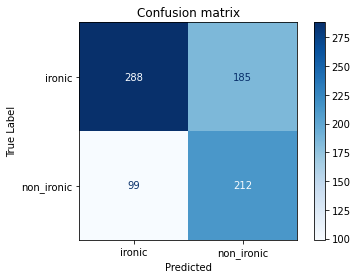

In [248]:
stats()